In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [192]:
# Load the dataset
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [193]:
# Step 2: Data Cleaning - Remove rows with missing BMI values
data = data.dropna(subset=['bmi'])

In [194]:
# Step 3: Features and target
X = data.drop(columns=['id', 'stroke'])
y = data['stroke']

In [195]:
# Step 4: Encode categorical variables
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)],
    remainder='passthrough')

In [196]:
# Apply preprocessing (encoding) before resampling
X_encoded = preprocessor.fit_transform(X)

In [197]:
# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

In [198]:
#Step 6: Apply SMOTE to oversample the minority class to 3000 samples
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [199]:
# Step 7: Apply undersampling only if the majority class has more than 3500 samples
#majority_class_count = y_train_resampled.value_counts()[0]

if majority_class_count > 3500:
    undersample = RandomUnderSampler(sampling_strategy={0: 3500}, random_state=42)
    X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_resampled, y_train_resampled)


In [200]:
# Step 8: Standardize the features
scaler = StandardScaler()
X_train_resampled= scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [201]:
# Step 9: Build the neural network model with Adamax optimizer and callbacks
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with Adamax optimizer and custom learning rate
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

c:\Users\ade14\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [202]:
# Define callbacks
callbacks_list = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Step 10: Train the model
history = model.fit(X_train_resampled, y_train_resampled, 
                    epochs=1000, batch_size=32, 
                    validation_split=0.2, 
                    callbacks=callbacks_list, 
                    verbose=1)

Epoch 1/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5913 - loss: 0.7291 - val_accuracy: 0.0046 - val_loss: 1.0025 - learning_rate: 1.0000e-04
Epoch 2/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6048 - loss: 0.7088 - val_accuracy: 0.0114 - val_loss: 0.9604 - learning_rate: 1.0000e-04
Epoch 3/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6145 - loss: 0.6711 - val_accuracy: 0.0167 - val_loss: 0.9238 - learning_rate: 1.0000e-04
Epoch 4/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6078 - loss: 0.6805 - val_accuracy: 0.0342 - val_loss: 0.8927 - learning_rate: 1.0000e-04
Epoch 5/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6103 - loss: 0.6597 - val_accuracy: 0.0509 - val_loss: 0.8671 - learning_rate: 1.0000e-04
Epoch 6/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6216 - loss: 0.6443 - val_accuracy: 0.0919 - val_loss: 0.8429 - learning_rate: 1.0000e-04
Epoch 7/1000
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

In [203]:
# Step 11: Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8581


In [204]:
# Step 12: Predictions and evaluation
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [205]:
# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1410
           1       0.14      0.43      0.21        63

    accuracy                           0.86      1473
   macro avg       0.55      0.65      0.56      1473
weighted avg       0.94      0.86      0.89      1473



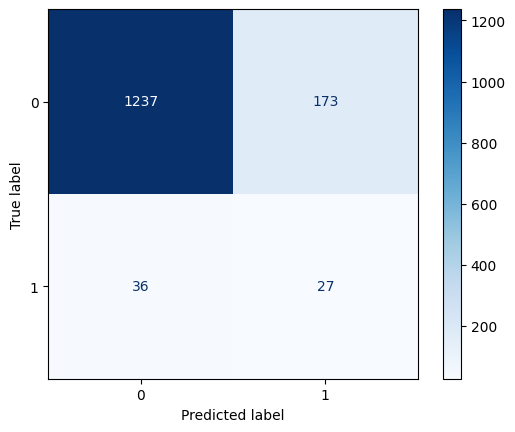

In [206]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [207]:
# Step 13: Save the model to a file
model.save('stroke_prediction_model.h5')
print("Model saved to stroke_prediction_model.h5")

Model saved to stroke_prediction_model.h5
